<h1>Predicción del crédito bancario al sector privado</h1>

Utilizamos los modelos generados para la prediccion de la serie de tiempo del credito bancario al sector privado. Para el modelado utilizamos un enfoque de aprendizaje profundo tipo encoder-decoder, usando LSTM como encoder y MLP's como decoders, la arquitectura del modelo se encuentra en la carpeta "arquitectura_modelos" y los modelos ya entrenados se encuentran en la carpeta "modelos".

Las series de tiempo se obtienen por medio de la API Banco de México con el propósito de que se puedan obtener y ajustar la estimación rápidamente ante la actualización de estas series.

In [1]:
from pathlib import Path
import os

os.chdir('C:/ABM/Analisis/Estimacion_Credito_Seq2seq')

# Buscar el primer directorio padre que contenga un archivo específico
def find_project_root(filename="requirements.txt"):
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / filename).exists():
            return parent
    raise FileNotFoundError(f"No se encontró {filename} en ningún directorio padre.")

# Establecer como root
os.chdir(find_project_root())
print("Nuevo directorio:", os.getcwd())

Nuevo directorio: C:\ABM\Analisis\Estimacion_Credito_Seq2seq


In [ ]:
# Importar librerias 

import numpy as np
import pandas as pd

from pandas.tseries.frequencies import to_offset

import matplotlib.pyplot as plt

from dotenv import load_dotenv

# Pytorch para redes neuroanles
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

# Importamos modulos propios
from procesamiento_datos import procesamiento_pron_pib
from api_caller.banxico import Banxico_SIE
from api_caller.inegi import INEGI_BIE

from arquitectura_modelos import MultivariateTimeSeriesDataset, Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster
from arquitectura_modelos.set_seed import set_seed


# Evitamos mensajes de advertencia
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga variables de un archivo .env (para almacenar el token de la API de Banxico)
load_dotenv()

# Token
BANXICO_TOKEN = os.environ.get("Banxico_Token")
INEGI_TOKEN = os.environ.get("INEGI_Token") 

banxico_api = Banxico_SIE(BANXICO_TOKEN)
inegi_api = INEGI_BIE(INEGI_TOKEN)

# Lectura de series

## Seies principales

In [4]:
# Descarga de series de banxico
fecha_inicio = '2010-01-01'

series_dict = {'SP1':'INPC', 'SR17622':'PIB', 'SR17693':'IGAE',
               'SF235401':'Credito_consumo', 'SF235410':'Credito_vivienda', 'SF235418':'Credito_empresas',}

# Series
series = banxico_api.get_data(list(series_dict.keys()), fecha_inicio=fecha_inicio)

# Se ordenan las columnas, se verifica que los datos son numericos y se cambia el nombre de las series
series = series.sort_index(axis=1)
series = series.apply(pd.to_numeric, errors='coerce')
series = series.rename(columns=series_dict)

# Calculamos la media mensual de la serie en caso de tener series con mayor desagregacion
series = series.resample('MS').mean()

In [5]:
# Calculamos el credito total al sector privado y dividimos por inpc para obtener el credito real
series['Credito_consumo_real'] = series['Credito_consumo'] / series['INPC']
series['Credito_vivienda_real'] = series['Credito_vivienda'] / series['INPC']
series['Credito_empresas_real'] = series['Credito_empresas'] / series['INPC']


series['Credito_SP'] = series['Credito_consumo'] + series['Credito_vivienda'] + series['Credito_empresas']
series['Credito_SP_real'] = series['Credito_consumo_real'] + series['Credito_vivienda_real'] + series['Credito_empresas_real']

## Pronosticos

In [6]:
# Definimos sobre que estadistica haremos los pronosticos
estadistico = 'mediana'

# Definimos el pronostico para el año t y t+1
pronosticos_def = {'t': 0.2,
                   't_1': 1.2
                   }

In [7]:
# Realizamos el procesamiento de los pronosticos de PIB (alinear resultados de pronosticos trimestrales y anuales)
trim_index, pron_anual_pib = procesamiento_pron_pib(banxico_api, pronosticos_def, estadistico)

# Procesamiento

In [8]:
# Quitamos los nan del inicio del dataframe
series = series[series['Credito_SP'].dropna().index.min():]

In [9]:
# Obtenemos las fechas de ultima observacion
last_cred_obs_date = series['Credito_SP'].dropna().index.max()

# Obtenemos las fechas de inicio y final de prediccion
initial_cred_pred_date = last_cred_obs_date + pd.DateOffset(months=1)
predict_cred_end_date = initial_cred_pred_date + pd.DateOffset(months=12*2)

In [10]:
# Reindexamos la serie para tener espacio para incluir los pronosticos en la frecuencia correcta
rango_mensual = pd.date_range(start=series.index.min(), end=predict_cred_end_date, freq='MS')
series = series.reindex(rango_mensual)

In [11]:
# Se incorporan los pronosticos definidos del PIB

for trim in trim_index:
    series.loc[trim,'PIB'] = series.loc[trim + pd.DateOffset(months=-12),'PIB'] * (1+pron_anual_pib.loc[trim].iloc[0]/100)


In [12]:
# Calculamos variaciones anuales de series de interés
series['IGAE_var'] = np.log(series['IGAE']).diff(12)*100
series['PIB_var'] = np.log(series['PIB']).diff(12)*100

series['Credito_consumo_real_var'] = np.log(series['Credito_consumo_real']).diff(12)*100
series['Credito_vivienda_real_var'] = np.log(series['Credito_vivienda_real']).diff(12)*100
series['Credito_empresas_real_var'] = np.log(series['Credito_empresas_real']).diff(12)*100
series['Credito_SP_real_var'] = np.log(series['Credito_SP_real']).diff(12)*100

In [13]:
# Obtenemos la distribucion del credito por segmento
dist_cred = series.copy().loc[:,['Credito_consumo','Credito_vivienda','Credito_empresas']]
dist_cred = dist_cred.loc[dist_cred.dropna().index]
dist_cred = dist_cred.iloc[-1,:]
dist_cred = dist_cred/dist_cred.sum()

## Proyeccion de IGAE con respecto a PIB

In [14]:
# Cargamos el modelo para predecir el movimiento del igae
igae_model_path = "modelos/IGAE_trim_seq2seq.pth"
igae_model = Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster.load_model(igae_model_path)

Modelo cargado desde modelos/IGAE_trim_seq2seq.pth


In [15]:
# Creamos una copia del dataframe para introducir al modelo
df_igae = series.copy().loc[series[igae_model.exog_cols].dropna().index, igae_model.target_cols + igae_model.exog_cols]
df_igae = df_igae[df_igae.dropna().index.min():]

In [16]:
# Obtenemos las fechas de ultima observacion del igae
last_igae_obs_date = df_igae[igae_model.target_cols].dropna().index.max()

# Obtenemos las fechas de inicio y final de prediccion
initial_igae_pred_date = last_igae_obs_date + pd.DateOffset(months=1)
predict_igae_end_date = initial_igae_pred_date + pd.DateOffset(months=12*2)

In [17]:
# Reindexamos la serie y rellenamos con interpolacion para tener todo el horizonte de pronostico en caso de no tenerlo
rango_pronostico = pd.date_range(start=df_igae.index.min(), end= max(predict_igae_end_date,predict_cred_end_date), freq='QS-Mar')
df_igae = df_igae.reindex(rango_pronostico)

# Se aplica interpolación lineal para rellenar los meses
df_igae[igae_model.exog_cols] = df_igae[igae_model.exog_cols].interpolate(method='linear')

In [18]:
# Predicciones del igae
igae_predictions = igae_model.predict(
    df = df_igae,
    target_col = igae_model.target_cols[0],
    initial_pred_date = df_igae[igae_model.target_cols[0]].dropna().index.max() + pd.DateOffset(months=3)
)

# Reindexamos la serie a frecuencia mensual para concatenarlo al dataframe principal
rango_mensual = pd.date_range(start=igae_predictions.index.min(), end= predict_cred_end_date, freq='MS')
igae_predictions = igae_predictions.reindex(rango_mensual)

# Se aplica interpolación lineal para rellenar los meses
igae_predictions = igae_predictions.interpolate(method='linear')

In [19]:
# Incorporamos la prediccion de la mediana del IGAE
series_proc = series.copy()
series_proc.loc[igae_predictions.index,'IGAE_var'] = igae_predictions['IGAE_var_50']

# Preparacion para prediccion

In [ ]:
# Cargamos el modelo para predecir el credito al sector privado
cred_model_path = "modelos/Credito_SP_seq2seq.pth"
cred_model_path = "modelos/seq2seq_Cred_SP.pth"
cred_model = Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster.load_model(cred_model_path)

Modelo cargado desde modelos/seq2seq_Cred_SP.pth


In [26]:
df = series_proc.copy().loc[series_proc[cred_model.exog_cols].dropna().index, cred_model.target_cols + cred_model.exog_cols]
df = df[df.dropna().index.min():]

# Prediccion

In [27]:
# Predicciones de todas las series
df_pred = df.copy()
for serie in cred_model.target_cols:
    predicciones = cred_model.predict(
    df = df,
    target_col = serie,
    initial_pred_date = initial_cred_pred_date
    )

    df_pred = pd.concat([df_pred, predicciones], axis=1)


# Acotar el DataFrame a las fechas de interés
df_pred = df_pred.loc[initial_cred_pred_date + pd.DateOffset(months=-12*2):(initial_cred_pred_date + pd.DateOffset(months=12*2))]

# Auxiliar
df_pred['Credito_SP_2_real_var'] = df_pred['Credito_SP_real_var']


In [28]:
# Calculamos la variacion anual real del credito al sector privado ponderando las estimaciones por segmento
quantiles = [0.05, 0.5, 0.95]
for quantile in [0.05, 0.5, 0.95]:
    df_pred[f'Credito_SP_2_real_var_{int(quantile*100)}'] = (df_pred[f'Credito_consumo_real_var_{int(quantile*100)}']*dist_cred['Credito_consumo'] + 
                                                             df_pred[f'Credito_vivienda_real_var_{int(quantile*100)}']*dist_cred['Credito_vivienda'] + 
                                                             df_pred[f'Credito_empresas_real_var_{int(quantile*100)}']*dist_cred['Credito_empresas']
                                                             )

In [29]:
#Fechas de interés
end_year_pred = pd.Timestamp(year=last_cred_obs_date.year, month=12, day=1)
end_year_1_pred = pd.Timestamp(year=last_cred_obs_date.year+1, month=12, day=1)

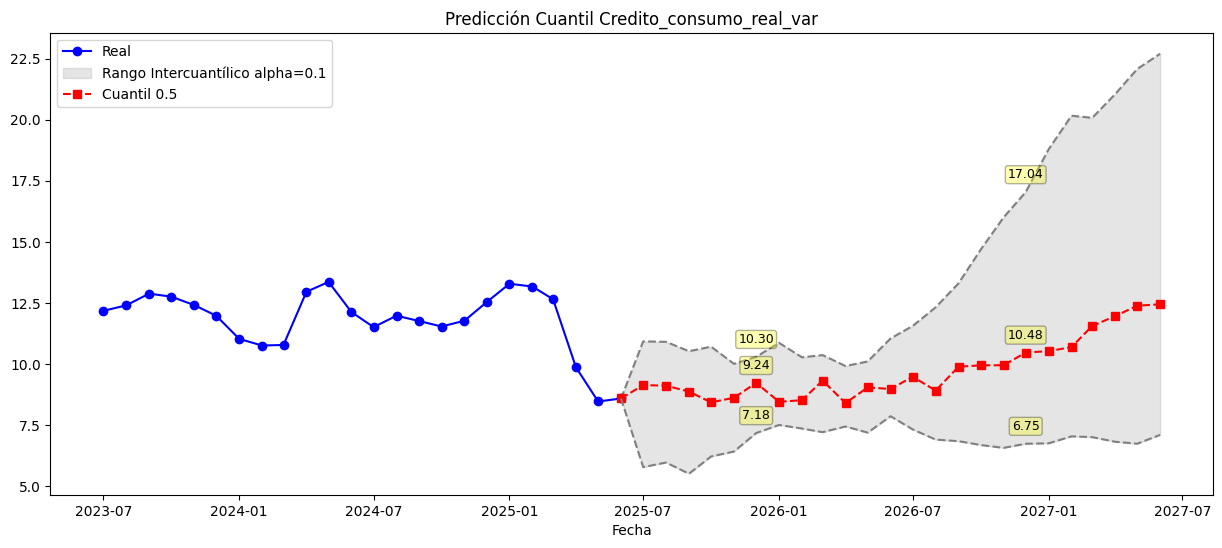

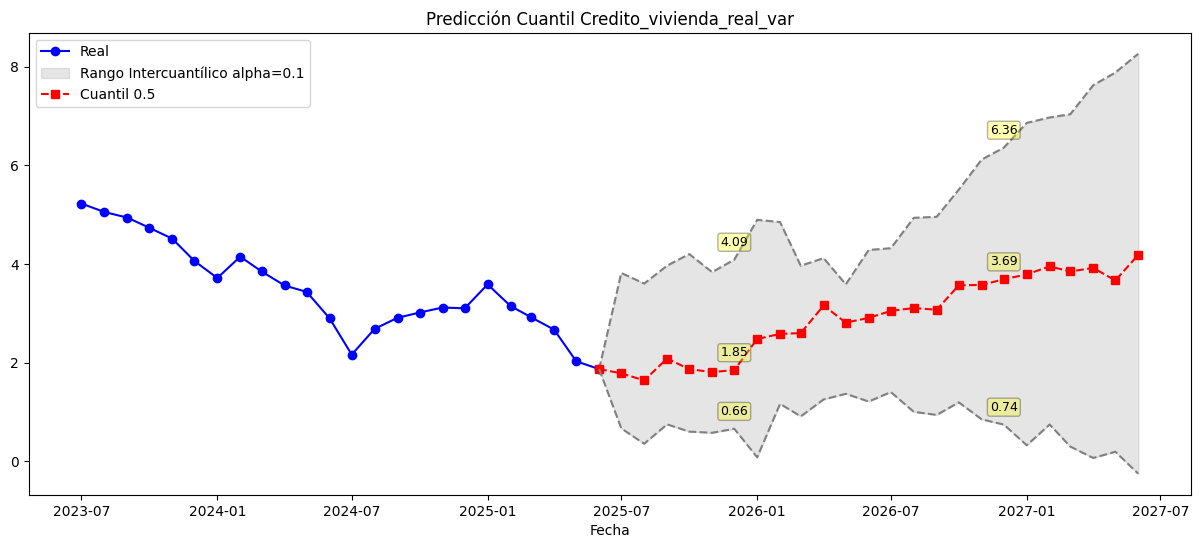

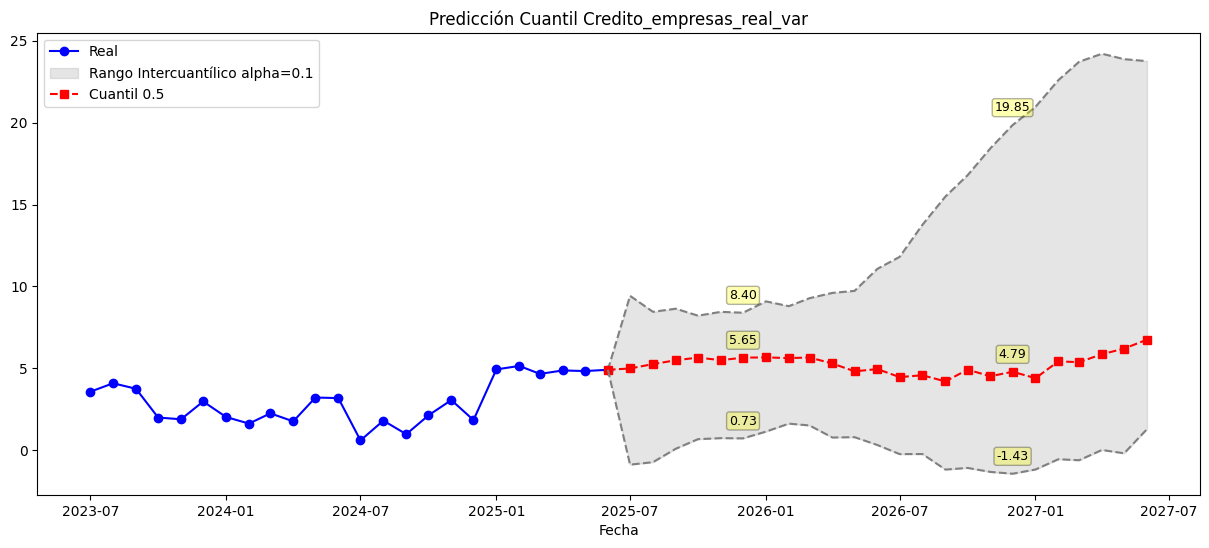

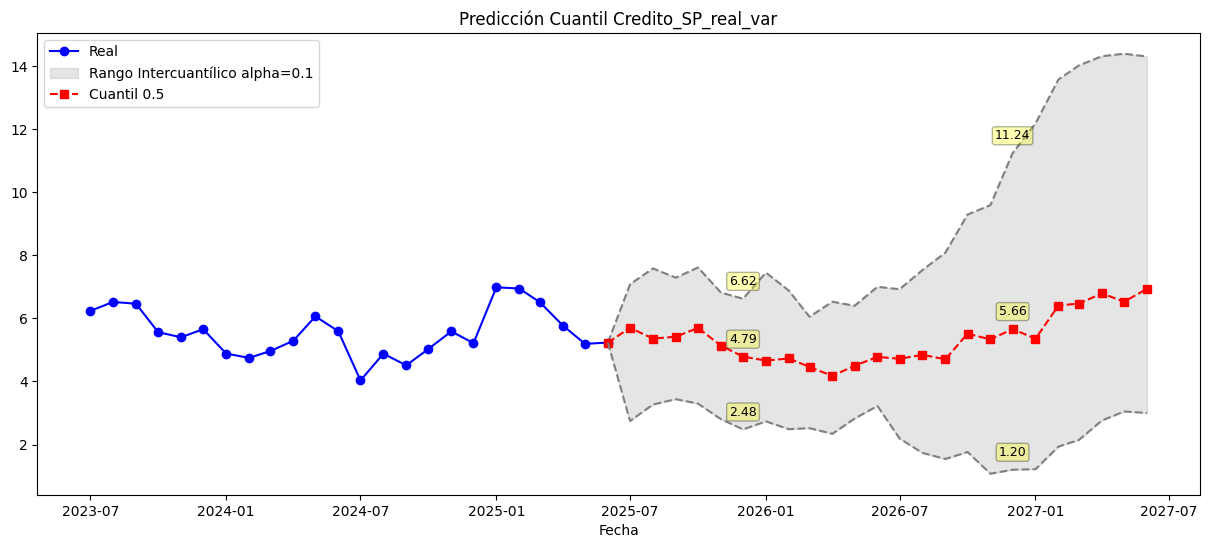

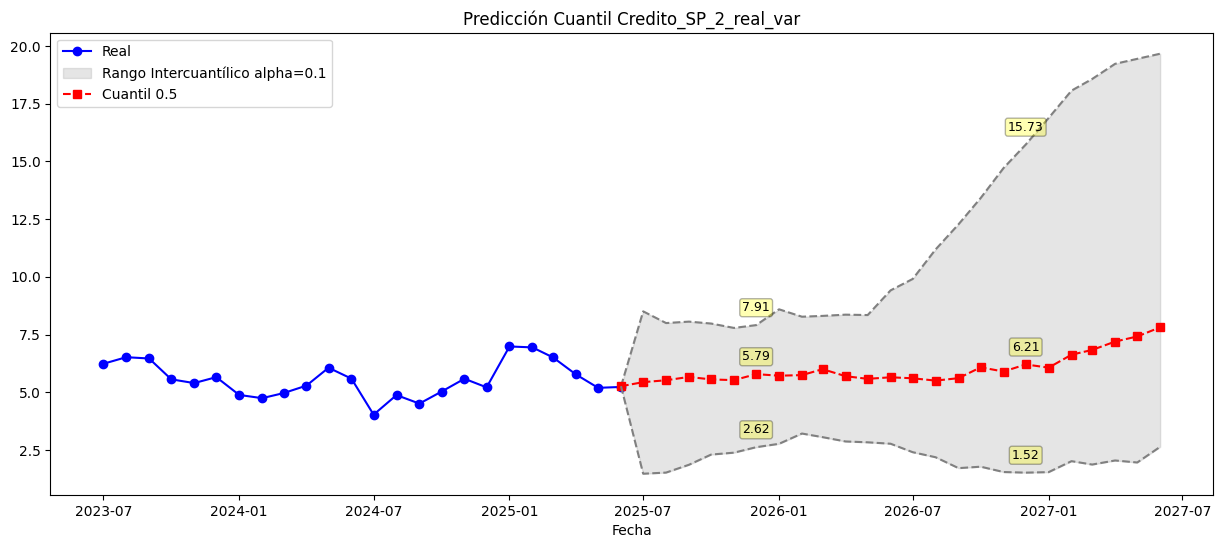

In [31]:
# Iterar sobre cada variable objetivo para crear una gráfica
for serie in (cred_model.target_cols + ['Credito_SP_2_real_var']):
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Graficar la serie real
    plt.plot(df_pred.index, df_pred[serie], label='Real', marker='o', linestyle='-', color='blue')

    if end_year_pred in df_pred.index:
        valor = df_pred.at[end_year_pred, serie]
        ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))
        
    if end_year_1_pred in df_pred.index:
        valor = df_pred.at[end_year_1_pred, serie]
        ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))
        
    plt.fill_between(df_pred.index, df_pred[f'{serie}_{int(quantiles[0]*100)}'], df_pred[f'{serie}_{int(quantiles[-1]*100)}'], color='gray', alpha=0.2, label='Rango Intercuantílico alpha=0.1')


    for quantile, color in zip(quantiles[::-1], ['gray', 'red', 'gray']):
        col_name = f'{serie}_{int(quantile*100)}'
        if col_name in df_pred.columns:
            if col_name == f'{serie}_50':
                plt.plot(df_pred.index, df_pred[col_name], label=f'Cuantil {quantile}', marker='s', linestyle='--', color=color)
            else:
                plt.plot(df_pred.index, df_pred[col_name], linestyle='--', color=color)

            if end_year_pred in df_pred.index:
                valor = df_pred.at[end_year_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
                
            if end_year_1_pred in df_pred.index:
                valor = df_pred.at[end_year_1_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))

    plt.xlabel('Fecha')

    plt.title(f'Predicción Cuantil {serie}')
    plt.legend()
    plt.show()

